In [324]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

import datetime
from dateutil.parser import isoparse
from ta import momentum, trend, volatility, volume

from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Optional: ensures that the line width doesn't truncate output

In [2]:
file = "daily_archives/daily_trading_data_2025-05-20.csv"

df_daily = pd.read_csv(file)

df_daily["TimeStamp"] = df_daily["TimeStamp"].apply(isoparse)
# Set the TimeStamp as the index (required for resampling).
df_daily.set_index("TimeStamp", inplace=True)

In [325]:
start_time = '2025-05-20 15:00:00'
end_time = '2025-05-20 22:15:00'

ticker = 'BABA' # symbol to analyze
freq = '60s'

# ema, sma parameters
ema_win = 20 # default 20
sma_win = 20 # default 20

# bb parameters
bb_win = 5 # default 20
bb_windev = 1.5 # default 2

# rsi parameters
rsi_win = 5 # default 14 
low_rsi = 35 # default 30
high_rsi = 75 # default 70

# atr parameters
atr_win = 14 # default 14

# adx parameters
adx_thresh = 20 # default 20
adx_win = 5 # default 14

# obv parameters
obv_win = 10 # default 1

df_daily = df_daily.loc[(df_daily.index >= start_time) & (df_daily.index <= end_time)]

print(df_daily.info(), '\n')

print('Number of unique rows:\n', df_daily.drop_duplicates().shape[0], '\n')
print(df_daily.nunique(), '\n')

df_daily


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 886176 entries, 2025-05-20 15:25:00.131802 to 2025-05-20 21:59:59.578509
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ConId       886176 non-null  int64  
 1   Symbol      886176 non-null  object 
 2   SecType     886176 non-null  object 
 3   Exchange    886176 non-null  object 
 4   Currency    886176 non-null  object 
 5   Bid_price   886176 non-null  float64
 6   Ask_price   886176 non-null  float64
 7   Last_price  886176 non-null  float64
 8   Volume      886176 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 67.6+ MB
None 

Number of unique rows:
 648790 

ConId              7
Symbol             7
SecType            1
Exchange           1
Currency           1
Bid_price       3152
Ask_price       3156
Last_price      3236
Volume        247264
dtype: int64 



,ConId,Symbol,SecType,Exchange,Currency,Bid_price,Ask_price,Last_price,Volume
TimeStamp,,,,,,,,,
2025-05-20 15:25:00.131802,72539702,TQQQ,STK,SMART,USD,70.74,70.76,70.79,40656.0
2025-05-20 15:25:00.132806,76792991,TSLA,STK,SMART,USD,347.14,347.40,347.14,36371.0
2025-05-20 15:25:00.132806,72539702,TQQQ,STK,SMART,USD,70.74,70.77,70.79,40656.0
2025-05-20 15:25:00.132806,76792991,TSLA,STK,SMART,USD,347.14,347.28,347.14,36371.0
2025-05-20 15:25:00.133622,677037673,IBIT,STK,SMART,USD,59.54,59.55,59.55,20727.0
...,...,...,...,...,...,...,...,...,...
2025-05-20 21:59:59.881023,76792991,TSLA,STK,SMART,USD,343.75,343.85,343.80,1260721.0
2025-05-20 21:59:59.881023,13272,UNH,STK,SMART,USD,321.55,321.59,321.56,397686.0
2025-05-20 21:59:59.879986,677037673,IBIT,STK,SMART,USD,60.90,60.91,60.90,474405.0


In [326]:
def ts_rate(ts_series):
    # Compute the duration in seconds between the max and min timestamps
    duration = (ts_series.max() - ts_series.min()).total_seconds()
    if duration == 0:
        # If duration is zero, return 0 or you can choose to return float('nan')
        return 0  
    return ts_series.nunique() / duration

# Group by 'Symbol' and compute the rate for the TS_Last_price column
rates = df_daily.groupby('Symbol').apply(lambda x: ts_rate(x.index)).reset_index(name='TimeStamps_per_sec')

print("Number of TimeStamps entries per second per Symbol:")
rates

Number of TimeStamps entries per second per Symbol:


C:\Users\Alienware\AppData\Local\Temp\ipykernel_52272\2365833682.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates = df_daily.groupby('Symbol').apply(lambda x: ts_rate(x.index)).reset_index(name='TimeStamps_per_sec')


,Symbol,TimeStamps_per_sec
0,BABA,0.955086
1,IBIT,1.356133
2,JD,0.534436
3,NVDA,4.031650
4,TQQQ,2.865600
5,TSLA,5.392420
6,UNH,2.336406


In [327]:
def last_price_rate(group):
    # Ensure the group is sorted by TimeStamp
    group = group.sort_index()
    
    # Create a boolean Series that is True when the price changes compared to the previous row
    # Note: The first row is automatically flagged, so subtract one if that isn’t desired.
    changes = group['Last_price'].ne(group['Last_price'].shift())
    change_count = changes.sum() 

    # Calculate how much time (in seconds) this group spans
    duration = (group.index.max() - group.index.min()).total_seconds()
    return change_count / duration

# Compute the rate per ticker by grouping by 'Symbol'
rates = df_daily.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')

print("Average number of Last Price changes per second per Symbol:")
rates

Average number of Last Price changes per second per Symbol:


C:\Users\Alienware\AppData\Local\Temp\ipykernel_52272\2302491163.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rates = df_daily.groupby('Symbol').apply(last_price_rate).reset_index(name='LastPriceRate')


,Symbol,LastPriceRate
0,BABA,0.264727
1,IBIT,0.397515
2,JD,0.130843
3,NVDA,1.448953
4,TQQQ,0.903301
5,TSLA,2.679944
6,UNH,1.296583


In [328]:
# count, mean, standard deviation, minimum, and maximum for Last_price.
stats_last = df_daily.groupby('Symbol').agg(
    count_last_price=('Last_price', 'count'),
    mean_last_price=('Last_price', 'mean'),
    std_last_price=('Last_price', 'std'),
    min_last_price=('Last_price', 'min'),
    max_last_price=('Last_price', 'max')
)
print("Last Price Statistics by Symbol:")
stats_last

Last Price Statistics by Symbol:


,count_last_price,mean_last_price,std_last_price,min_last_price,max_last_price
Symbol,,,,,
BABA,53496,124.714223,0.200445,124.10,125.22
IBIT,87321,59.975732,0.445953,59.21,61.05
JD,44905,34.152708,0.155411,33.88,34.46
NVDA,202164,133.756002,0.394616,132.62,134.70
TQQQ,159400,70.513907,0.342758,69.40,71.17
TSLA,232639,347.810053,2.969906,341.66,354.98
UNH,106251,319.777437,2.870930,312.58,324.64


In [329]:
# count, mean, standard deviation, minimum, and maximum for Volume.
stats_volume = df_daily.groupby('Symbol').agg(
    count_volume=('Volume', 'count'),
    mean_volume=('Volume', 'mean'),
    std_volume=('Volume', 'std'),
    min_volume=('Volume', 'min'),
    max_volume=('Volume', 'max')
)
print("\nVolume Statistics by Symbol:")
stats_volume


Volume Statistics by Symbol:


,count_volume,mean_volume,std_volume,min_volume,max_volume
Symbol,,,,,
BABA,53496,45955.936836,18119.545675,5083.0,77323.0
IBIT,87321,224190.424778,121160.074077,20727.0,474405.0
JD,44905,55859.189199,27785.543756,2000.0,102619.0
NVDA,202164,820281.170886,369353.648237,45142.0,1460878.0
TQQQ,159400,329391.153645,161432.155276,40656.0,652157.0
TSLA,232639,692440.220552,318247.808447,36371.0,1260721.0
UNH,106251,230332.386227,100807.029766,20721.0,397686.0


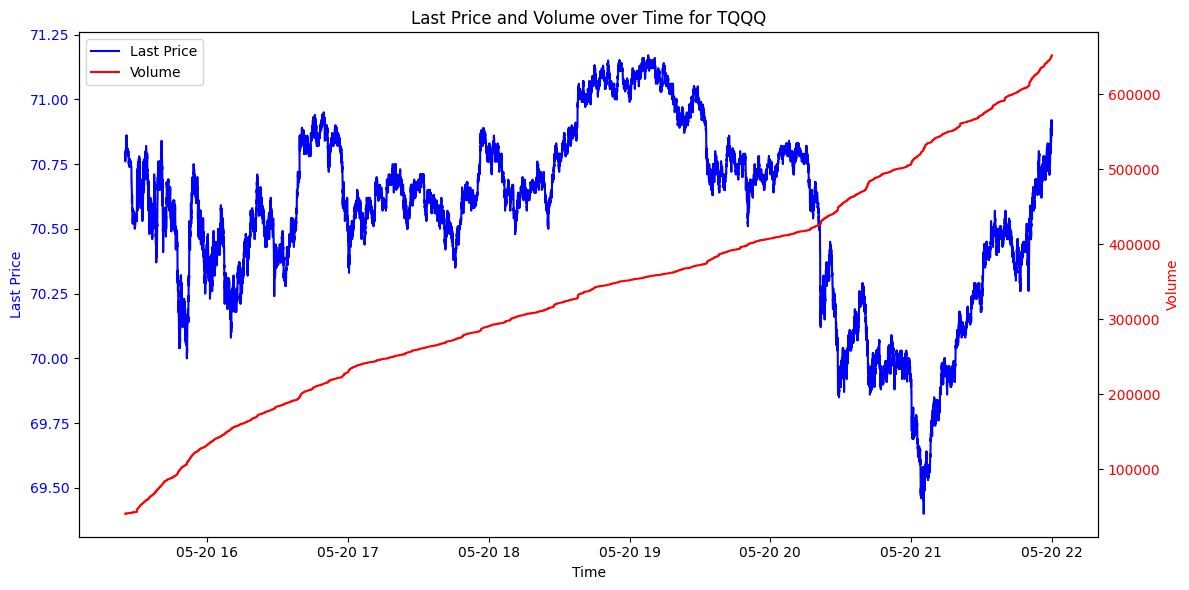

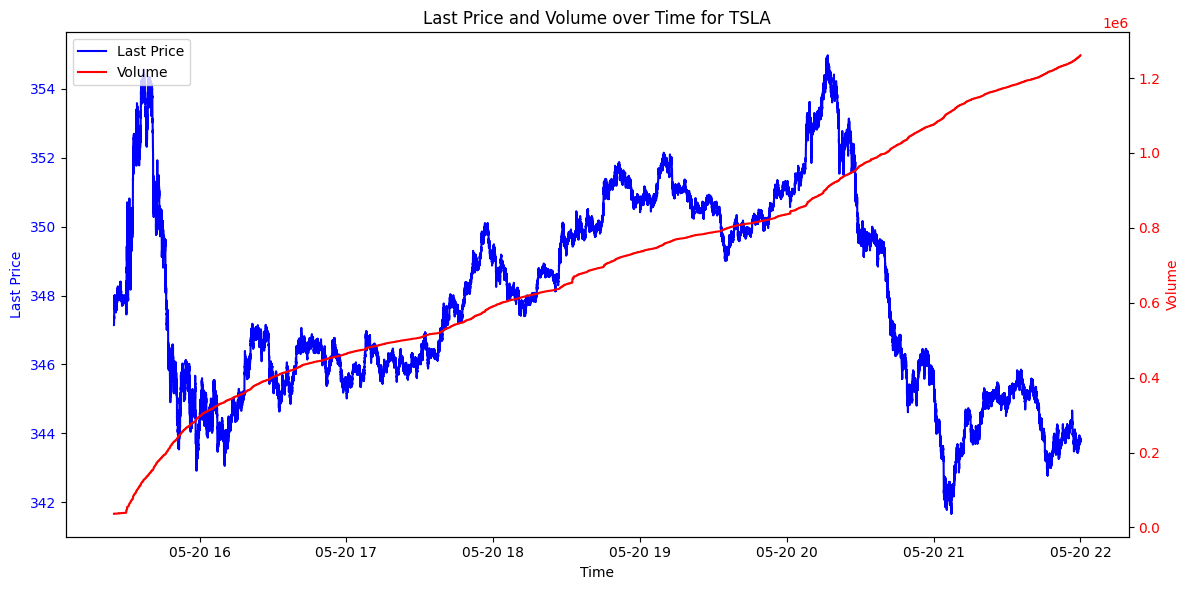

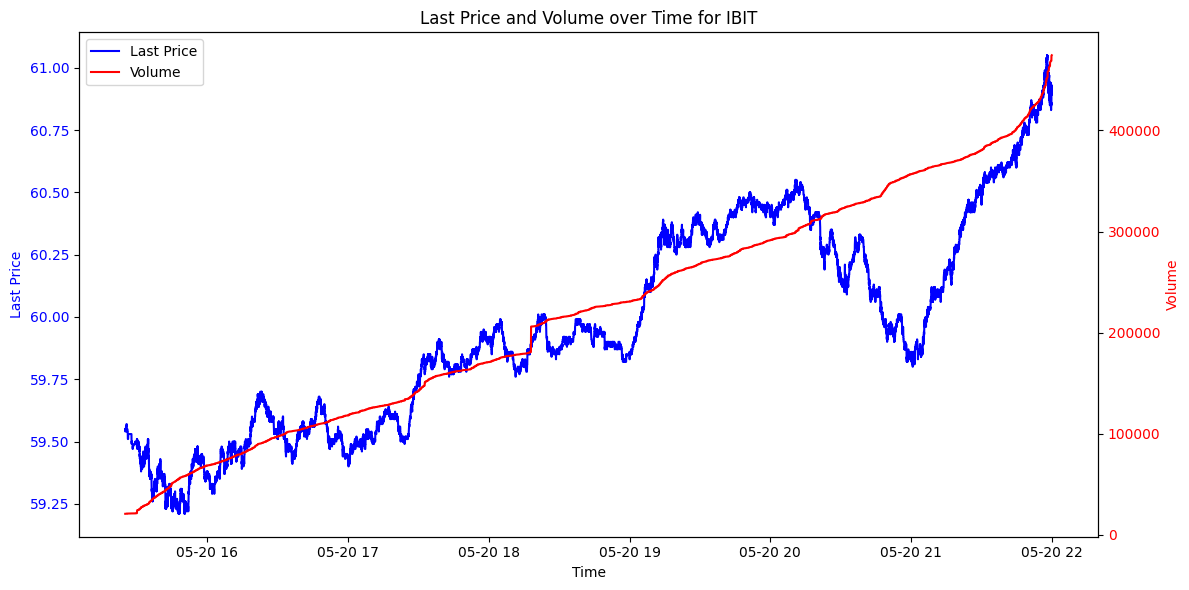

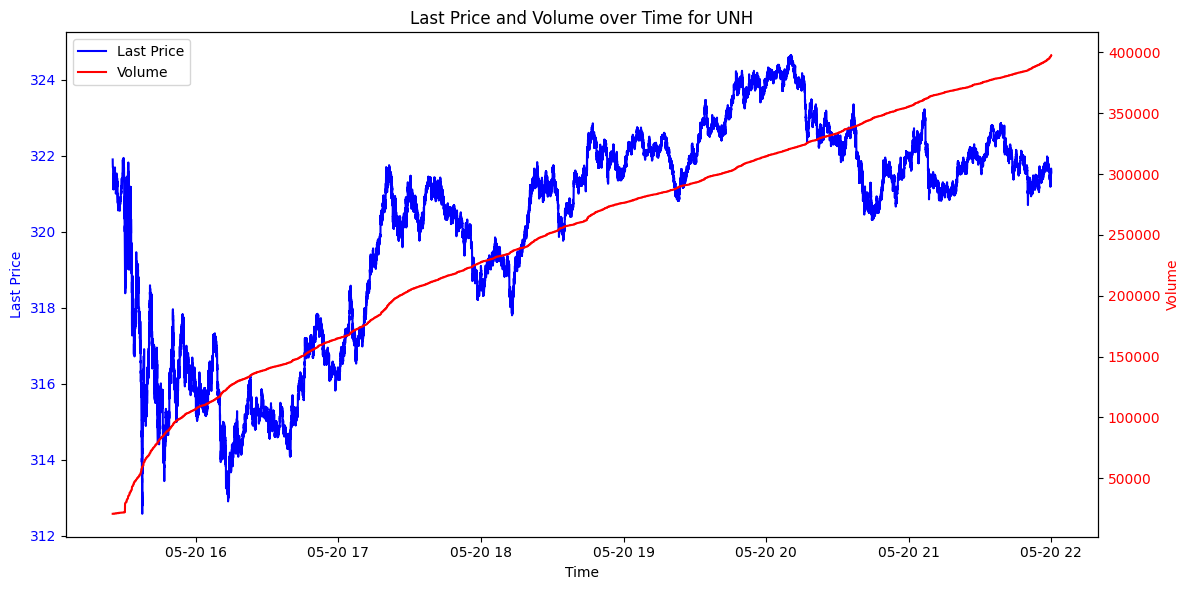

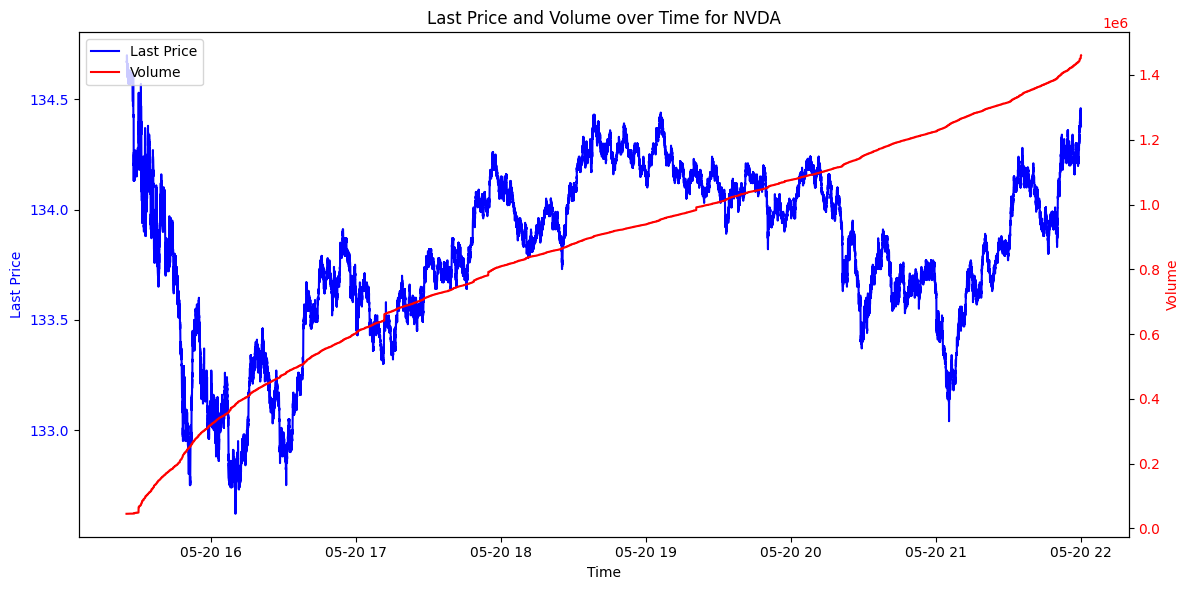

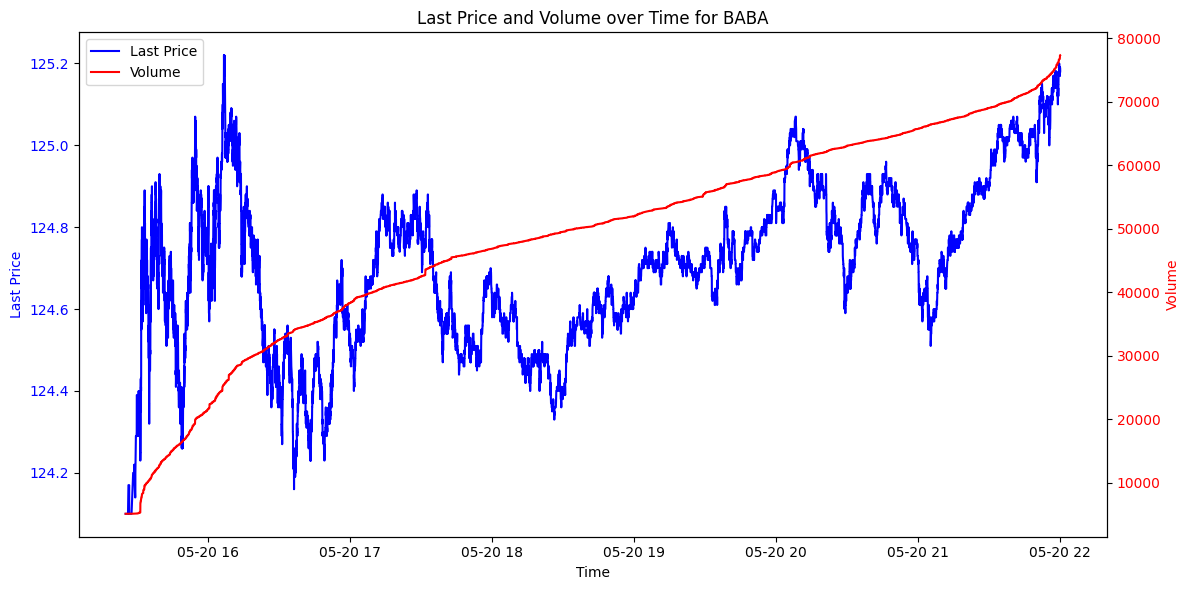

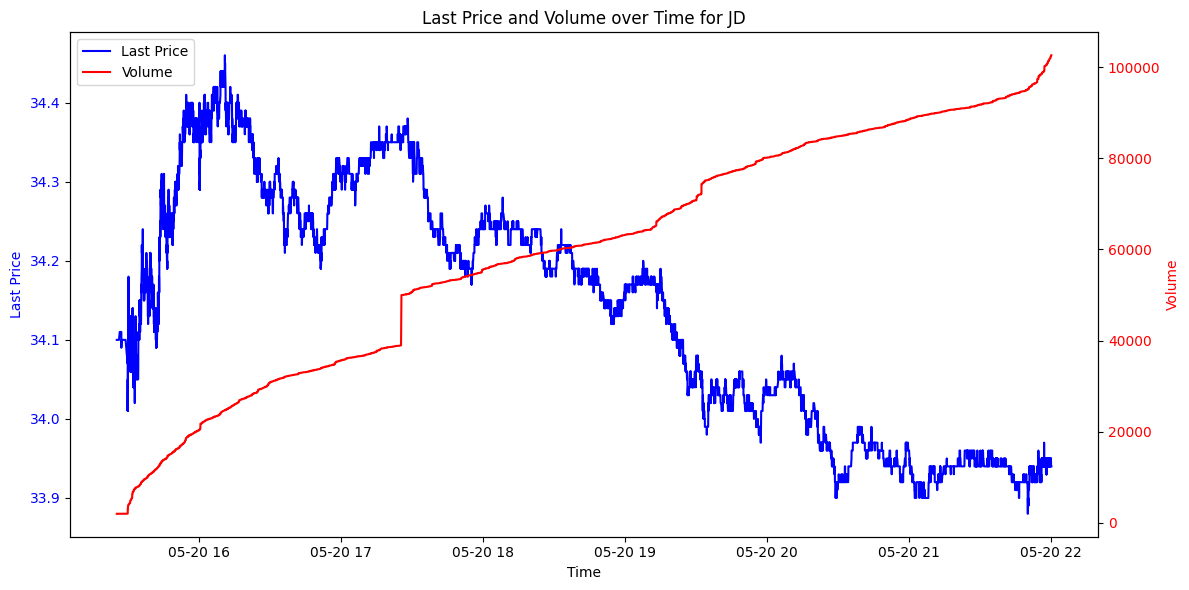

In [330]:
# Get all unique symbols.
symbols = df_daily['Symbol'].unique()


for sym in symbols:
    # Filter the data for the specific symbol
    df_sym = df_daily[df_daily['Symbol'] == sym]
    
    # Create a new figure and first axis for Last_price.
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot Last_price over time (using TS_Last_price).
    lns1 = ax1.plot(df_sym.index, df_sym['Last_price'], 
                    label='Last Price', color='blue')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Last Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a twin Axes sharing the same x-axis for Volume.
    ax2 = ax1.twinx()
    lns2 = ax2.plot(df_sym.index, df_sym['Volume'],
                    label='Volume', color='red')
    ax2.set_ylabel('Volume', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Optionally, combine legends from both axes.
    lns = lns1 + lns2
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='upper left')
    
    # Set a title and a bit of margin if desired.
    plt.title(f'Last Price and Volume over Time for {sym}')
    plt.tight_layout()
    plt.show()


In [331]:
# # Loop over each symbol
# for sym in symbols:
#     # Filter data for the specific symbol
#     df_sym = df_daily[df_daily['Symbol'] == sym]
    
#     # Create a new figure for the boxplot
#     plt.figure(figsize=(10,6))
    
#     # # Option 1: Using a single-variable boxplot
#     sns.boxplot(x=df_sym['Last_price'])
#     plt.xlabel('Last Price')
    
#     # Option 2 (if you prefer to show the symbol category):  
#     # sns.boxplot(x='Symbol', y='Last_price', data=df_sym)
#     # This will display the symbol on the x-axis (though there is only one category).
    
#     plt.title(f'Distribution of Last Price for {sym}')
#     plt.tight_layout()
#     plt.show()


In [332]:
# # Loop over each symbol and create an individual histogram.
# for sym in symbols:
#     df_sym = df_daily[df_daily['Symbol'] == sym]
#     plt.figure(figsize=(10, 6))
    
#     # Option 1: Using Matplotlib's plt.hist
#     plt.hist(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
#     # Option 2: Using Seaborn's histplot (uncomment if you prefer)
#     # sns.histplot(df_sym['Last_price'], bins=30, color='steelblue', edgecolor='black')
    
#     plt.xlabel('Last Price')
#     plt.ylabel('Frequency')
#     plt.title(f'Histogram of Last Price for {sym}')
#     plt.tight_layout()
#     plt.show()


In [333]:


# -------------------------------
# Visualizations
# -------------------------------   

def visualize_indicators():

    # Note: We're setting sharex=False so every subplot displays its own x-axis.
    fig, axs = plt.subplots(nrows=12, ncols=1, figsize=(18, 70), sharex=False)
    fig.suptitle("Technical Indicators and Engineered (Unified) Signals\nwith Close Price Overlay", fontsize=20)
    
    # =======================================================
    # Row 0: Moving Averages
    # =======================================================
    # Left panel: Raw Moving Averages (dotted lines)
    ax00 = axs[0]
    ax00.plot(ohlc.index, ohlc["ema"], label="EMA", linestyle=":", color="green")
    ax00.plot(ohlc.index, ohlc["sma"], label="SMA", linestyle=":", color="red")
    ax00.set_ylabel("Price")
    ax00.legend(loc="upper left")
    ax00.set_title("Raw: Moving Averages")
    # Secondary axis: Close Price
    ax00_twin = ax00.twinx()
    ax00_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax00_twin.set_ylabel("Close Price")
    ax00_twin.legend(loc="upper right")
    
    # Right panel: Engineered MA feature 
    ax01 = axs[1]
    ax01.plot(ohlc.index, ohlc["ma_feature"].where(ohlc["ma_feature"] > 0),
             label="Buy Feature", color="green", linestyle="-", linewidth=2)
    ax01.plot(ohlc.index, ohlc["ma_feature"].where(ohlc["ma_feature"] < 0),
             label="Sell Feature", color="red", linestyle="-", linewidth=2)
    ax01.axhline(0, color="gray", linestyle="--")
    ax01.set_ylabel("MA Feature")
    ax01.legend(loc="upper left")
    ax01.set_title("Engineered: MA Signal")
    # Secondary axis: Close Price
    ax01_twin = ax01.twinx()
    ax01_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax01_twin.set_ylabel("Close Price")
    ax01_twin.legend(loc="upper right")
    
    # =======================================================
    # Row 1: MACD
    # =======================================================
    # Left panel: Raw MACD and Signal (dotted)
    ax10 = axs[2]
    ax10.plot(ohlc.index, ohlc["macd"], label="MACD", linestyle=":", color="green")
    ax10.plot(ohlc.index, ohlc["macd_signal"], label="Signal", linestyle=":", color="red")
    ax10.set_ylabel("MACD")
    ax10.legend(loc="upper left")
    ax10.set_title("Raw: MACD")
    ax10.set_xlabel("Time")
    # Secondary axis: Close Price
    ax10_twin = ax10.twinx()
    ax10_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax10_twin.set_ylabel("Close Price")
    ax10_twin.legend(loc="upper right")
    
    # Right panel: Engineered MACD feature
    ax11 = axs[3]
    ax11.plot(ohlc.index, ohlc["macd_feature"].where(ohlc["macd_feature"] > 0),
             label="Buy Feature", color="green", linestyle="-", linewidth=2)
    ax11.plot(ohlc.index, ohlc["macd_feature"].where(ohlc["macd_feature"] < 0),
             label="Sell Feature", color="red", linestyle="-", linewidth=2)
    ax11.axhline(0, color="gray", linestyle="--")
    ax11.set_ylabel("MACD Feature")
    ax11.legend(loc="upper left")
    ax11.set_title("Engineered: MACD Signal")
    ax11.set_xlabel("Time")
    # Secondary axis: Close Price
    ax11_twin = ax11.twinx()
    ax11_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax11_twin.set_ylabel("Close Price")
    ax11_twin.legend(loc="upper right")
    
    # =======================================================
    # Row 2: Bollinger Bands
    # =======================================================
    # Left panel: Raw Bollinger Bands (dotted)
    ax20 = axs[4]
    ax20.plot(ohlc.index, ohlc["bb_mavg"], label="BB Mid", linestyle=":", color="magenta")
    ax20.plot(ohlc.index, ohlc["bb_hband"], label="BB High", linestyle=":", color="green")
    ax20.plot(ohlc.index, ohlc["bb_lband"], label="BB Low", linestyle=":", color="red")
    ax20.set_ylabel("Price")
    ax20.legend(loc="upper left")
    ax20.set_title("Raw: Bollinger Bands")
    # Secondary axis: Close Price
    ax20_twin = ax20.twinx()
    ax20_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax20_twin.set_ylabel("Close Price")
    ax20_twin.legend(loc="upper right")
    
    # Right panel: Engineered Bollinger Bands feature 
    ax21 = axs[5]
    ax21.plot(ohlc.index, ohlc["bb_feature"].where(ohlc["bb_feature"] > 0),
             label="Buy Feature", color="green", linestyle="-", linewidth=2)
    ax21.plot(ohlc.index, ohlc["bb_feature"].where(ohlc["bb_feature"] < 0),
             label="Sell Feature", color="red", linestyle="-", linewidth=2)
    ax21.axhline(0, color="gray", linestyle="--")
    ax21.set_ylabel("BB Feature")
    ax21.legend(loc="upper left")
    ax21.set_title("Engineered: BB Signal")
    # Secondary axis: Close Price
    ax21_twin = ax21.twinx()
    ax21_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax21_twin.set_ylabel("Close Price")
    ax21_twin.legend(loc="upper right")
    
    # =======================================================
    # Row 3: RSI
    # =======================================================
    # Left panel: Raw RSI (dotted) with thresholds
    ax30 = axs[6]
    ax30.plot(ohlc.index, ohlc["rsi"], label="RSI", linestyle=":", color="magenta")
    ax30.axhline(low_rsi, color="gray", linestyle="--", linewidth=0.8)
    ax30.axhline(high_rsi, color="gray", linestyle="--", linewidth=0.8)
    ax30.set_ylabel("RSI")
    ax30.legend(loc="upper left")
    ax30.set_title("Raw: RSI")
    # Secondary axis: Close Price
    ax30_twin = ax30.twinx()
    ax30_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax30_twin.set_ylabel("Close Price")
    ax30_twin.legend(loc="upper right")
    
    # Right panel: Engineered RSI feature 
    ax31 = axs[7]
    ax31.plot(ohlc.index, ohlc["rsi_feature"].where(ohlc["rsi_feature"] > 0),
             label="Buy Feature", color="green", linestyle="-", linewidth=2)
    ax31.plot(ohlc.index, ohlc["rsi_feature"].where(ohlc["rsi_feature"] < 0),
             label="Sell Feature", color="red", linestyle="-", linewidth=2)
    ax31.axhline(0, color="gray", linestyle="--")
    ax31.set_ylabel("RSI Feature")
    ax31.legend(loc="upper left")
    ax31.set_title("Engineered: RSI Signal")
    # Secondary axis: Close Price
    ax31_twin = ax31.twinx()
    ax31_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax31_twin.set_ylabel("Close Price")
    ax31_twin.legend(loc="upper right")
    
    # =======================================================
    # Row 4: ADX & Directional Indicators
    # =======================================================
    # Left panel: Raw ADX, +DI and -DI (dotted)
    ax40 = axs[8]
    ax40.plot(ohlc.index, ohlc["adx"], label="ADX", linestyle=":", color="purple")
    ax40.plot(ohlc.index, ohlc["plus_di"], label="+DI", linestyle=":", color="green")
    ax40.plot(ohlc.index, ohlc["minus_di"], label="-DI", linestyle=":", color="red")
    ax40.axhline(adx_thresh, color="gray", linestyle=":", linewidth=1.5)
    ax40.set_ylabel("ADX / DI")
    ax40.legend(loc="upper left")
    ax40.set_title("Raw: ADX & DI")
    ax40.set_xlabel("Time")
    # Secondary axis: Close Price
    ax40_twin = ax40.twinx()
    ax40_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax40_twin.set_ylabel("Close Price")
    ax40_twin.legend(loc="upper right")
    
    # Right panel: Engineered ADX feature 
    ax41 = axs[9]
    ax41.plot(ohlc.index, ohlc["adx_feature"].where(ohlc["adx_feature"] > 0),
             label="Buy Feature", color="green", linestyle="-", linewidth=2)
    ax41.plot(ohlc.index, ohlc["adx_feature"].where(ohlc["adx_feature"] < 0),
             label="Sell Feature", color="red", linestyle="-", linewidth=2)
    ax41.axhline(0, color="gray", linestyle="--")
    ax41.set_ylabel("ADX Feature")
    ax41.legend(loc="upper left")
    ax41.set_title("Engineered: ADX Signal")
    ax41.set_xlabel("Time")
    # Secondary axis: Close Price
    ax41_twin = ax41.twinx()
    ax41_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax41_twin.set_ylabel("Close Price")
    ax41_twin.legend(loc="upper right")
    
    # =======================================================
    # Row 5: OBV
    # =======================================================
    # Left panel: Raw OBV (dotted)
    ax50 = axs[10]
    ax50.plot(ohlc.index, ohlc["obv"], label="OBV", linestyle=":", color="magenta")
    ax50.set_ylabel("OBV")
    ax50.legend(loc="upper left")
    ax50.set_title("Raw: OBV")
    # Secondary axis: Close Price
    ax50_twin = ax50.twinx()
    ax50_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax50_twin.set_ylabel("Close Price")
    ax50_twin.legend(loc="upper right")
    
    # Right panel: Engineered OBV feature 
    ax51 = axs[11]
    ax51.plot(ohlc.index, ohlc["obv_feature"].where(ohlc["obv_feature"] > 0),
             label="Buy Feature", color="green", linestyle="-", linewidth=2)
    ax51.plot(ohlc.index, ohlc["obv_feature"].where(ohlc["obv_feature"] < 0),
             label="Sell Feature", color="red", linestyle="-", linewidth=2)
    ax51.axhline(0, color="gray", linestyle="--")
    ax51.set_ylabel("OBV Feature")
    ax51.legend(loc="upper left")
    ax51.set_title("Engineered: OBV Signal")
    # Secondary axis: Close Price
    ax51_twin = ax51.twinx()
    ax51_twin.plot(ohlc.index, ohlc["close"], label="Close", color="black", linewidth=2, alpha=0.7)
    ax51_twin.set_ylabel("Close Price")
    ax51_twin.legend(loc="upper right")
    
    # --------------------------------------------------
    # Set x-axis tick locator and formatter for every subplot.
    locator = mdates.MinuteLocator(byminute=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])
    formatter = mdates.DateFormatter("%H:%M")  # Display only hour and minute
    
    for ax in axs.flatten():
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
        # Enable vertical grid lines at major ticks with a very thin line.
        ax.grid(True, which='major', axis='x', linestyle='-', linewidth=0.3, color='gray')
    
    
    # Increase vertical spacing between rows to clearly visualize dates on every subplot.
    plt.subplots_adjust(hspace=1.5)
    
    # Add a common x-axis label for the entire figure.
    fig.supxlabel("Time")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


In [334]:
# -------------------------------
# Calculate the Continuous "True Signal", shifting the pct_change, in order to use our features to predict the future pct_change
# -------------------------------

def ml_analysis():
    # Compute the percentage change in the closing price.
    ohlc["price_pct_change"] = ohlc["close"].pct_change().shift(-1)
    
    columns = feature_cols + ['price_pct_change']
    
    # 1. Normalize/standardize the data
    scaler = StandardScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(ohlc[columns]), 
                           columns=columns, 
                           index=ohlc_ticker.index)
    
    # Plot histograms for all columns 
    df_norm.hist(bins=30, figsize=(15, 10))
    plt.suptitle("Histograms of all columns", y=0.92)
    plt.show()

    heatmap()
    corr_matrix()
    scatter()
    
    df_norm

In [335]:
# ------------------------------------------
# (A) Create a Heatmap of the Time Evolution
# ------------------------------------------

def heatmap():
    # Transpose so that each row represents one variable (feature/target)
    df_heatmap = df_norm.T
    
    plt.figure(figsize=(12, 4))
    sns.heatmap(df_heatmap, cmap='coolwarm', center=0, cbar_kws={'label': 'Standardized Value'})
    plt.title('Heatmap of Standardized Technical Signals and Target')
    plt.xlabel('Time Index')
    plt.ylabel('Variable')
    plt.show()

# ------------------------------------------
# (B) Create a Correlation Matrix
# ------------------------------------------

def corr_matrix():
    # Compute the correlation matrix of your normalized DataFrame.
    corr_matrix = df_norm.corr()
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create an annotation matrix with percentage labels
    annot = corr_matrix.map(lambda x: f"{x*100:.2f}%")
    
    # Plot the heatmap using only the lower triangle and with percentage annotations.
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=annot, cmap='coolwarm',
                center=0, fmt="", square=True, cbar_kws={"shrink": .75})
    plt.title('Correlation Matrix (Standardized Features)')
    plt.show()

# ------------------------------------------
# (C) Scatter Plots for Each Feature vs. Target
# ------------------------------------------

def scatter():
    for feature in feature_cols:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df_norm[feature], y=df_norm[target_col].squeeze())
        plt.title(f'{feature} vs. price_pct_change (Standardized)')
        plt.xlabel(f'{feature} (Standardized)')
        plt.ylabel('price_pct_change (Standardized)')
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='gray', linestyle='--')
        plt.show()


In [336]:
def simulate_generic_trading(indicator):
    """
    Simulate trading with a generic approach over the session from 15:30 to 22:00:
    
      - Add +1 share when the indicator becomes positive and the previous signal was strictly negative (or None).
      - Subtract 1 share when the indicator becomes negative and the previous signal was strictly positive (or None),
        but only if you hold any shares.
      - Trading actions are only taken if the timestamp is between 15:30 (inclusive) and 22:00 (exclusive).
      
    Additionally, the function computes performance statistics using only data within this session:
      - Final Net Value: Final net portfolio value.
      - Buy & Hold Gain: Difference between the final close and the initial close within the session.
      - Strategy Profit Difference: Final Net Value minus Buy & Hold Gain.
      
    It also computes the following percentages (based on the initial price from within the session):
      - Final Net Return (%)
      - Buy & Hold Return (%)
      - Strategy Improvement (%): (Profit Difference / Buy & Hold Gain)*100
      
    The augmented simulation DataFrame is saved as a CSV and a tuple with the DataFrame and a dictionary of performance stats is returned.
    """
    # First, filter the DataFrame to the trading session period.
    session_df = ohlc_ticker.between_time('15:30', '22:00').copy()
    
    # If no data in session, return an empty DataFrame and stats.
    if session_df.empty:
        print("No data available in the trading session.")
        return session_df, {}
    
    position = 0  # Number of shares held
    cash = 0      # Starting cash (for simulation purposes)
    
    positions = []     # To track positions
    cash_balances = [] # To track cash balance
    net_values = []    # To track (cash + position * price)
    actions = []       # To record trade actions
    
    previous_signal = None  # To store the previous indicator value
    
    # Define the allowed trading period.
    trade_start = datetime.time(15, 30)
    trade_end = datetime.time(22, 0)
    
    # Loop over the filtered session DataFrame.
    for timestamp, row in session_df.iterrows():
        price = row['close']
        signal = row[indicator]
        current_time = timestamp.time()
        
        # Even though we've filtered the DataFrame, we double-check the time.
        if trade_start <= current_time < trade_end:
            action = "Hold"
            if pd.notna(signal):
                # Buy condition: Only buy if the signal becomes positive (and previous signal was strictly negative)
                if signal > 0 and (previous_signal is None or previous_signal < 0):
                    position += 1
                    cash -= price
                    action = "Buy"
                # Sell condition: Only sell if the signal becomes negative (and previous signal was strictly positive)
                # and you hold shares.
                elif signal < 0 and (previous_signal is None or previous_signal > 0) and position > 0:
                    position -= 1
                    cash += price
                    action = "Sell"
            else:
                action = "No signal"
        else:
            action = "No trade"
        
        previous_signal = signal
        positions.append(position)
        cash_balances.append(cash)
        net_values.append(cash + position * price)
        actions.append(action)
    
    # Rebuild the session DataFrame with simulation results.
    df_sim = session_df[[indicator, 'close']].copy()
    df_sim['Position'] = positions
    df_sim['Cash'] = cash_balances
    df_sim['NetValue'] = net_values
    df_sim['Action'] = actions
    
    # Save simulation results.
    df_sim.to_csv(f'backtest/df_sim_{ticker}_{indicator}.csv', index=True)
    
    # Compute performance statistics using only data in the session.
    initial_price = session_df.iloc[0]['close']
    final_price = session_df.iloc[-1]['close']
    buy_hold_gain = final_price - initial_price  # Buy & Hold Gain for one share in the session.
    final_net_value = net_values[-1]              # Final net portfolio value from the strategy.
    profit_diff = final_net_value - buy_hold_gain   # Difference between strategy and buy & hold.
    
    # Percentages (relative to the initial price).
    final_net_return_pct = (final_net_value / initial_price) * 100
    buy_hold_return_pct = (buy_hold_gain / initial_price) * 100
    strategy_improve_pct = (profit_diff / buy_hold_gain * 100) if buy_hold_gain != 0 else None
    
    performance_stats = {
        'Final Net Value ($)': final_net_value,
        'Buy & Hold Gain ($)': buy_hold_gain,
        'Strategy Profit Difference ($)': profit_diff,
        'Final Net Return (%)': final_net_return_pct,
        'Buy & Hold Return (%)': buy_hold_return_pct,
        'Strategy Improvement (%)': strategy_improve_pct
    }
    
    print('Performance Statistics over stock', ticker, 'for the indicator', indicator)
    for key, value in performance_stats.items():
        print(key, value)
    
    return df_sim, performance_stats

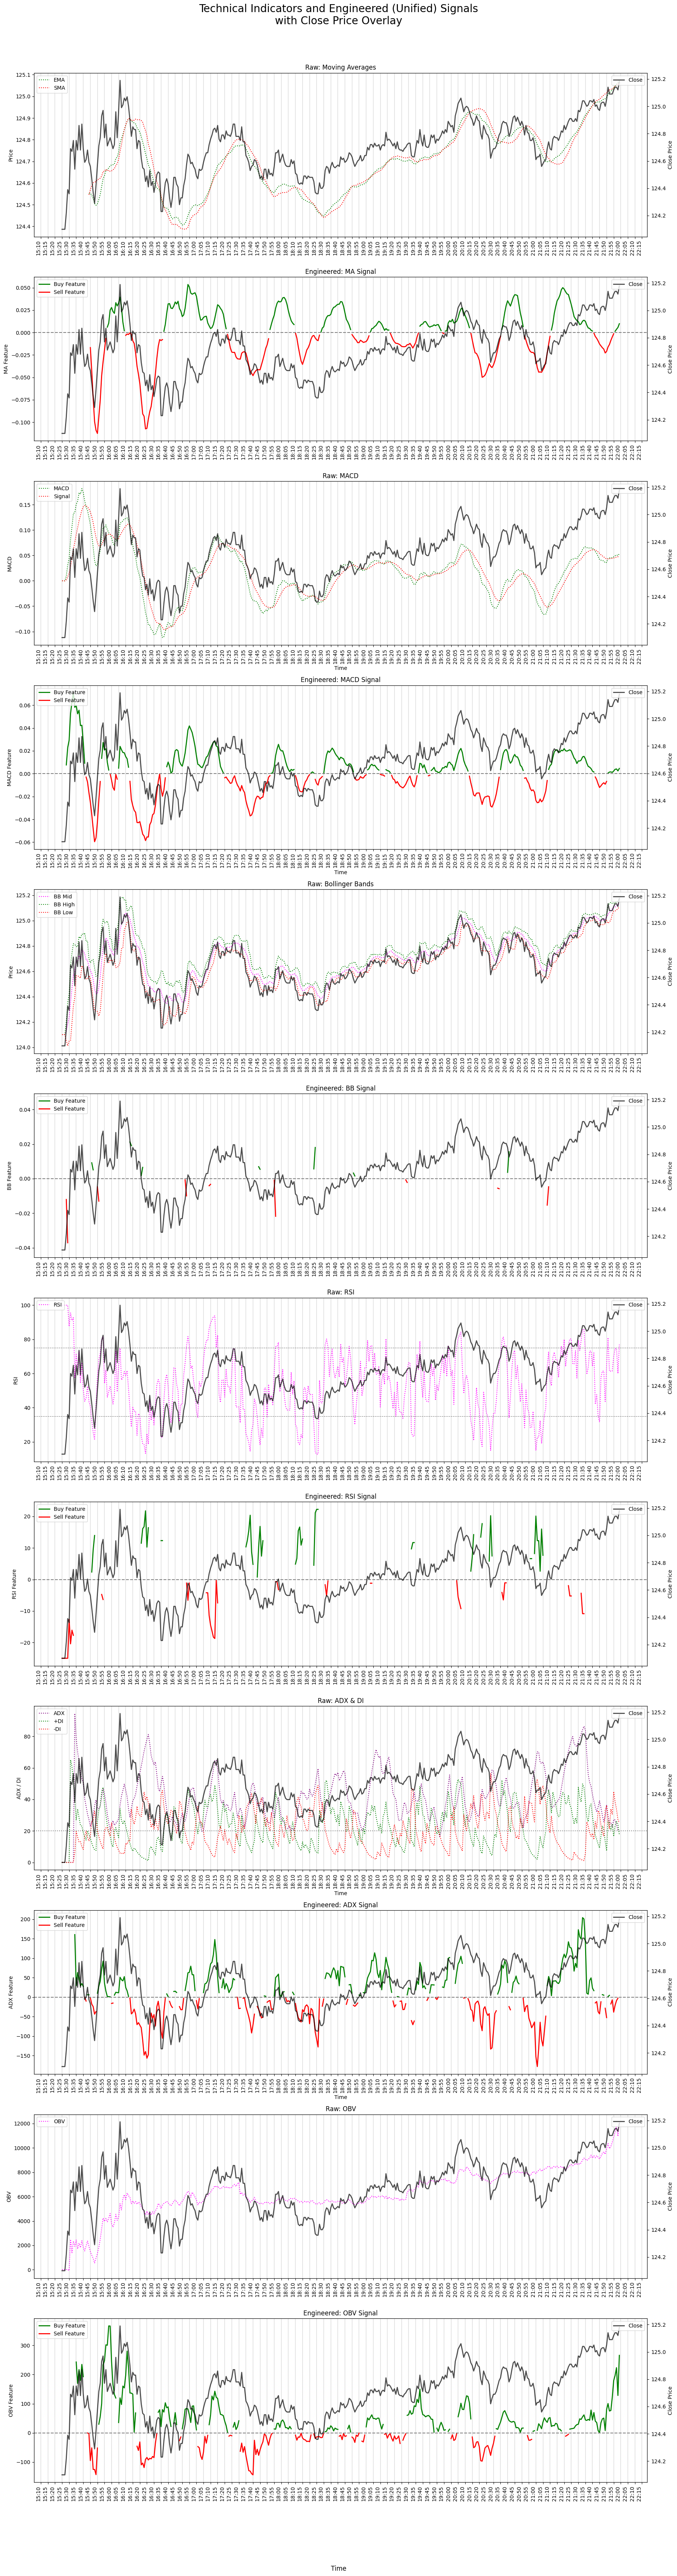

Performance Statistics over stock BABA for the indicator ma_feature
Final Net Value ($) 1.450000000000017
Buy & Hold Gain ($) 0.8200000000000074
Strategy Profit Difference ($) 0.6300000000000097
Final Net Return (%) 1.1659697651978265
Buy & Hold Return (%) 0.6593760051463553
Strategy Improvement (%) 76.82926829268342


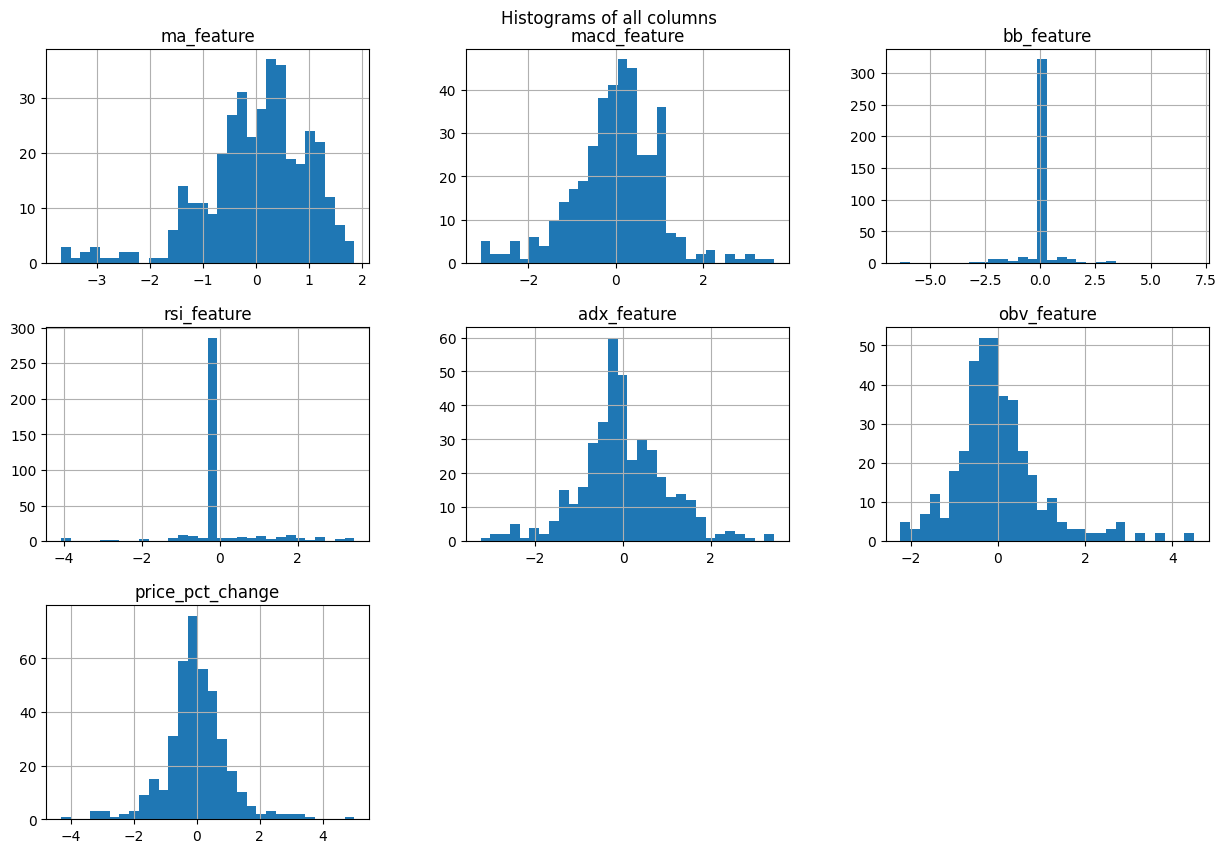

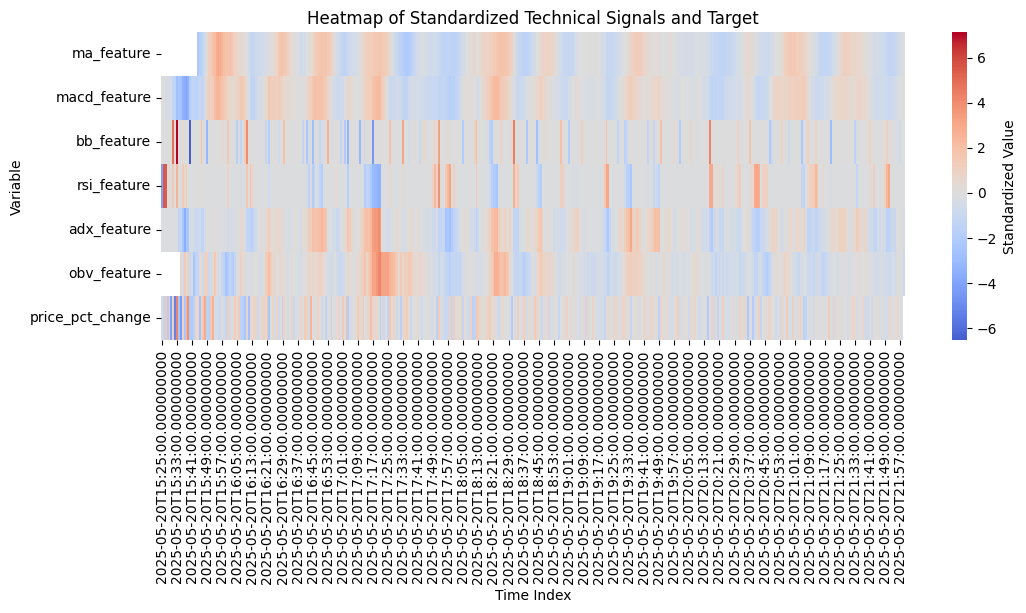

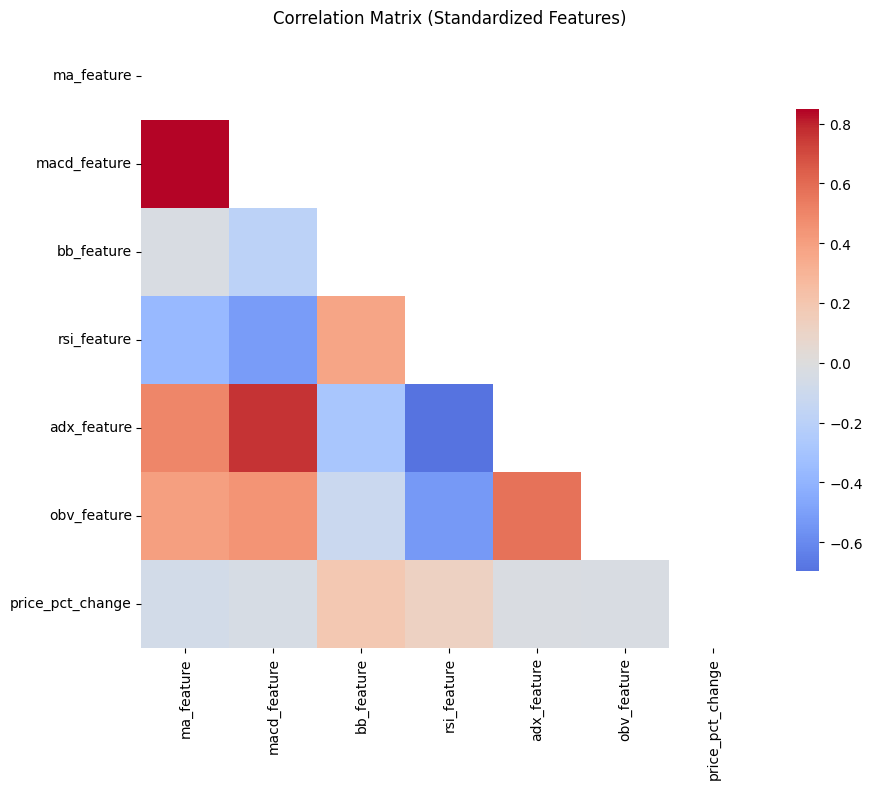

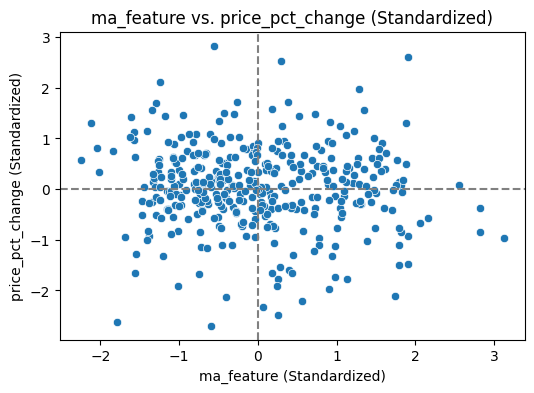

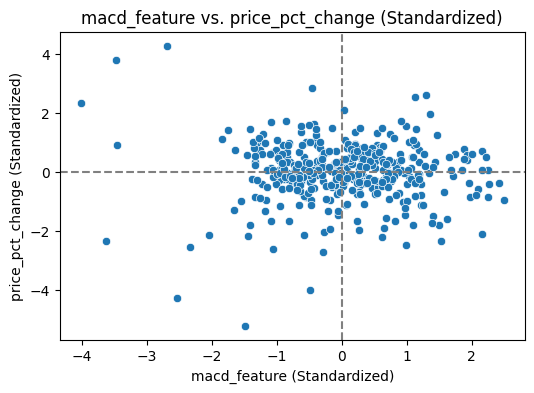

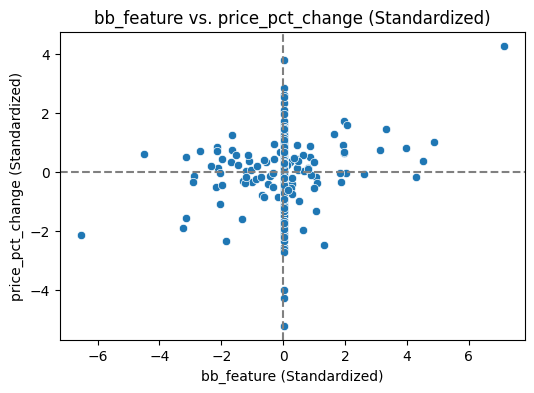

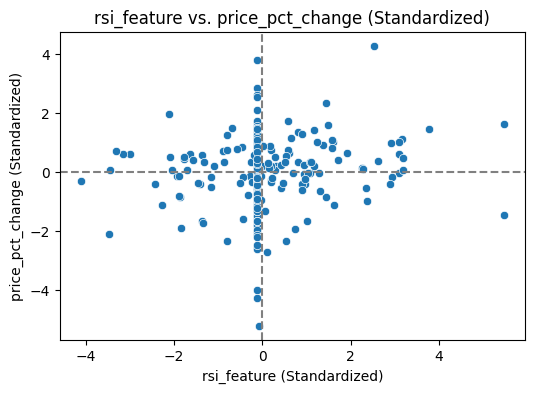

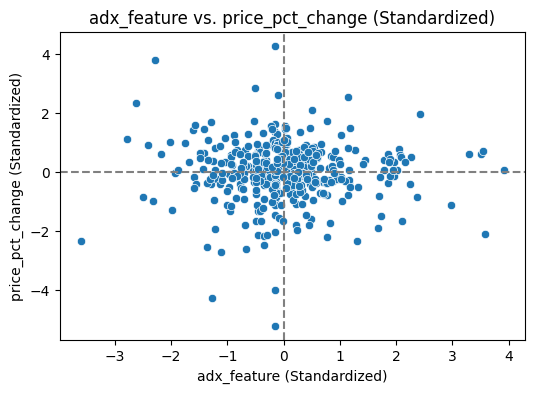

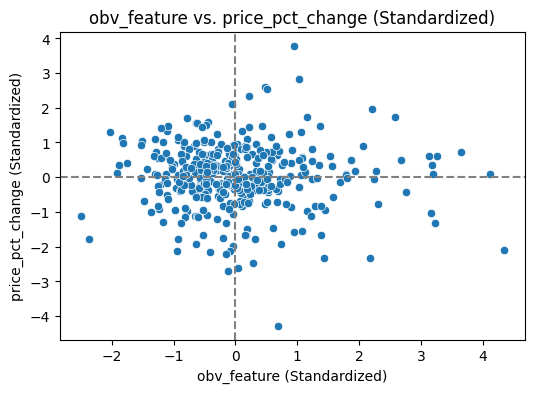

In [337]:
# A helper function to aggregate volume.
# being "Volume" a cumulative (running) total for the day, we cannot simply sum the values over the candle period
# we need to compute the difference between the last and first volume values in each resampled interval
def volume_diff(x):
    # If there's only one record in the bucket, the traded volume is 0.
    if len(x) < 2:
        return 0
    return x.iloc[-1] - x.iloc[0]

for symbol, group in df_daily.groupby("Symbol"):
    # Resample the 'Last_price' per symbol to compute OHLC candles for the defined interval.
    ohlc = group["Last_price"].resample(freq).ohlc()
    
    # Use the custom aggregation for cumulative volume:
    # Calculate the difference between the last and first tick of each candle.
    if "Volume" in group.columns:
        ohlc["volume"] = group["Volume"].resample(freq).agg(volume_diff)


    # Optionally, add the Symbol as a column for easier identification.
    ohlc["symbol"] = symbol

    # ================================
    # Compute Technical Indicators
    # ================================
    
    # Moving Averages: (window)-period SMA and EMA from the "close" price.
    # ohlc["sma"] = ohlc["close"].rolling(window=sma_win, min_periods=1).mean()
    ohlc["sma"] = ohlc["close"].rolling(window=sma_win, min_periods=sma_win).mean()
    # ohlc["ema"] = ohlc["close"].ewm(span=ema_win, adjust=False).mean()
    ohlc["ema"] = ohlc["close"].ewm(span=ema_win, adjust=False, min_periods=ema_win).mean()


    # MACD: using standard parameters (fast=12, slow=26, signal=9)
    macd_indicator = trend.MACD(close=ohlc["close"], window_fast=12, window_slow=26, window_sign=9, fillna=True)
    ohlc["macd"] = macd_indicator.macd()           # MACD line
    ohlc["macd_signal"] = macd_indicator.macd_signal()  # Signal line
    ohlc["macd_diff"] = macd_indicator.macd_diff()      # Histogram

    # Bollinger Bands: eg 20-period moving average with 2 standard deviations.
    bb_indicator = volatility.BollingerBands(close=ohlc["close"], window=bb_win, window_dev=bb_windev, fillna=True)
    ohlc["bb_mavg"] = bb_indicator.bollinger_mavg()   # Middle band
    ohlc["bb_hband"] = bb_indicator.bollinger_hband()   # Upper band
    ohlc["bb_lband"] = bb_indicator.bollinger_lband()   # Lower band
    
    # RSI: eg 14-period (using the close price)
    rsi_indicator = momentum.RSIIndicator(close=ohlc["close"], window=rsi_win, fillna=True)
    ohlc["rsi"] = rsi_indicator.rsi()
    
    # Average True Range (ATR): eg 14-period ATR using high, low, close.
    # Note: Here we use the OHLC prices that were derived from Last_price, which might not capture the full high/low variability.
    atr_indicator = volatility.AverageTrueRange(high=ohlc["high"], low=ohlc["low"], close=ohlc["close"], window=atr_win, fillna=True)
    ohlc["atr"] = atr_indicator.average_true_range()
    
    # ADX: eg 14-period ADX indicator for trend strength.
    adx_indicator = trend.ADXIndicator(high=ohlc["high"], low=ohlc["low"], close=ohlc["close"], window=adx_win, fillna=True)
    ohlc["adx"] = adx_indicator.adx()
    ohlc["plus_di"] = adx_indicator.adx_pos()
    ohlc["minus_di"] = adx_indicator.adx_neg()
    
    # On-Balance Volume (OBV):
    # OBV calculates cumulative volume by adding volume on up moves and subtracting on down moves.
    obv_indicator = volume.OnBalanceVolumeIndicator(close=ohlc["close"], volume=ohlc["volume"], fillna=True)
    ohlc["obv"] = obv_indicator.on_balance_volume()
    ohlc["obv_sma"] = ohlc["obv"].rolling(window=obv_win).mean()

    
    # ================================
    # Generate Trading Features, from Buy, Sell, Hold Signals
    # ================================
    
    # 1. Moving Averages Feature (already one unique value)
    ohlc["ma_feature"] = ohlc["ema"] - ohlc["sma"]
    
    # 2. MACD Feature (already unique)
    ohlc["macd_feature"] = ohlc["macd"] - ohlc["macd_signal"]
    
    # 3. Bollinger Bands Feature:
    # - If close < lower band, then signal = (lower band - close) (a positive number)
    # - If close > upper band, then signal = -(close - upper band) (a negative number)
    # - Else, signal = 0
    bb_buy  = np.where(ohlc["close"] < ohlc["bb_lband"], ohlc["bb_lband"] - ohlc["close"], 0)
    bb_sell = np.where(ohlc["close"] > ohlc["bb_hband"], -(ohlc["close"] - ohlc["bb_hband"]), 0)
    ohlc["bb_feature"] = bb_buy + bb_sell
    
    # 4. RSI Feature:
    # Define thresholds (you can adjust these values)
    # - If RSI is below low threshold, signal = (low_rsi - RSI) (positive)
    # - If RSI is above high threshold, signal = -(RSI - high_rsi) (negative)
    # - Else, signal = 0
    rsi_buy  = np.where(ohlc["rsi"] < low_rsi, low_rsi - ohlc["rsi"], 0)
    rsi_sell = np.where(ohlc["rsi"] > high_rsi, -(ohlc["rsi"] - high_rsi), 0)
    ohlc["rsi_feature"] = rsi_buy + rsi_sell
    
    # 5. ADX with Directional Indicators Feature:
    # Only produce a signal when ADX >= adx_thresh.
    # If plus_di > minus_di, signal = (plus_di - minus_di) * (adx/adx_thresh)
    # If minus_di > plus_di, signal = -(minus_di - plus_di) * (adx/adx_thresh)
    ohlc["adx_feature"] = np.where(
        ohlc["adx"] >= adx_thresh,
        np.where(ohlc["plus_di"] > ohlc["minus_di"],
                 (ohlc["plus_di"] - ohlc["minus_di"]) * (ohlc["adx"] / adx_thresh),
                 -(ohlc["minus_di"] - ohlc["plus_di"]) * (ohlc["adx"] / adx_thresh)
                ),
        0
    )
    
    # 6. OBV Feature:
    # Use the difference in OBV as the indicator.
    ohlc["obv_feature"] = ohlc["obv_sma"].diff()

    if (ohlc["symbol"] == ticker).all():
        visualize_indicators()

        # List all columns that end with '_feature'
        feature_cols = [col for col in ohlc.columns if col.endswith('_feature')]
        # Save the filtered DataFrame into the dictionary 
        ohlc_ticker = ohlc[feature_cols + ['close']]
        
        stats = simulate_generic_trading('ma_feature')

        ml_analysis()

